# Explorations in Visualisation of Alice Thornton's Books
## Event Dates

The dates of events encoded in the [TEI-XML of Alice Thornton's books](https://github.com/kingsdigitallab/alice-thornton/tree/edition?tab=readme-ov-file) are made in [Extended Date/Time Format (EDTF)](https://www.loc.gov/standards/datetime/) Specification by Library of Congress.

We can load these from the `entities.json` that is created by the [indexing process](https://github.com/kingsdigitallab/alice-thornton/blob/main/.github/workflows/index-entities.yml) for the [web search](https://thornton.kdl.kcl.ac.uk/entities/). At the moment only the `develop` branch has the [XSLT that includes the dates](https://github.com/kingsdigitallab/alice-thornton/blob/df629c4deaf394e7be4e50ea27eca06edf5824bc/apps/entities/tei-to-json.xsl#L119), so the entities with dates file has been copied here for convenience as `entities-with-dates.json`.

In [140]:
%matplotlib inline

In [141]:
import datetime
import json
import time
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown

In [142]:
# Load JSON file with events and dates into a Pandas datafram
with open('entities-with-dates.json', 'r') as file:
    entities = json.load(file)

df = pd.DataFrame(entities['data'])

# Filter to get just the events (not people or places)
event_df = df[df['type'] == 'event'].copy()
event_df.head()

,type,id,sortkey,search,title,subtype,region,settlement,pages,books,bio,cat,date
2,event,aow1_1595_child_accident,Accident/danger: Alice Wandesford saved from c...,Accident/danger Alice Wandesford saved from ch...,Accident/danger: Alice Wandesford saved from c...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1595%
3,event,cw1_1610_accident,Accident/danger: Christopher Wandesford (fathe...,Accident/danger Christopher Wandesford (father...,Accident/danger: Christopher Wandesford (fathe...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1608~
4,event,awt1_1638_fire,Accident/danger: Fire at Dublin Castle,Accident/danger Fire at Dublin Castle,Accident/danger: Fire at Dublin Castle,NaN,NaN,NaN,{'book_one': ['291-291']},[book_one],NaN,Accident/danger,1638~
5,event,awt1_1636_fire,Accident/danger: Fire at the Wandesford house ...,Accident/danger Fire at the Wandesford house i...,Accident/danger: Fire at the Wandesford house ...,NaN,NaN,NaN,"{'book_of_remembrances': ['21-21'], 'book_one'...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1636/1638
6,event,awt1_1650_promise_gw1,Accident/danger: George Wandesford promised Th...,Accident/danger George Wandesford promised Tho...,Accident/danger: George Wandesford promised Th...,NaN,NaN,NaN,{'book_of_remembrances': ['191-192']},[book_of_remembrances],NaN,Accident/danger,1650~


In [143]:
# See if Pandas can handle the date format automagically (spoiler: it does not!)
event_df['date_reg'] = pd.to_datetime(event_df['date'], errors='coerce')
event_df['date_reg'].head()

/tmp/ipykernel_317459/1619900638.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



2   NaT
3   NaT
4   NaT
5   NaT
6   NaT
Name: date_reg, dtype: datetime64[ns]

In [144]:
# Tidy up Panda's mess
event_df.drop('date_reg', axis=1, inplace=True)

## EDTF library for parsing dates

Fortunately, there is a nice Python library on PyPi for parsing EDTF dates: [edtf](https://pypi.org/project/edtf/). 

We take the approach of storing `EDTFObject`s in the dataframe; these encapsulate the uncertainties that are encoded in the date format.

### Parse the dates

In [145]:
from edtf import parse_edtf, struct_time_to_date
from edtf import EDTFParseException

# Function to parse EDTF dates into EDTFObject
def parse_edtf_date(date_str):
    try:
        return parse_edtf(date_str) 
    except EDTFParseException:
        return None


In [146]:
# Parse the dates and create a new column with EDTFObject
event_df['date_edtf'] = event_df['date'].apply(parse_edtf_date)
event_df.head()

,type,id,sortkey,search,title,subtype,region,settlement,pages,books,bio,cat,date,date_edtf
2,event,aow1_1595_child_accident,Accident/danger: Alice Wandesford saved from c...,Accident/danger Alice Wandesford saved from ch...,Accident/danger: Alice Wandesford saved from c...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1595%,1595%
3,event,cw1_1610_accident,Accident/danger: Christopher Wandesford (fathe...,Accident/danger Christopher Wandesford (father...,Accident/danger: Christopher Wandesford (fathe...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1608~,1608~
4,event,awt1_1638_fire,Accident/danger: Fire at Dublin Castle,Accident/danger Fire at Dublin Castle,Accident/danger: Fire at Dublin Castle,NaN,NaN,NaN,{'book_one': ['291-291']},[book_one],NaN,Accident/danger,1638~,1638~
5,event,awt1_1636_fire,Accident/danger: Fire at the Wandesford house ...,Accident/danger Fire at the Wandesford house i...,Accident/danger: Fire at the Wandesford house ...,NaN,NaN,NaN,"{'book_of_remembrances': ['21-21'], 'book_one'...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1636/1638,1636/1638
6,event,awt1_1650_promise_gw1,Accident/danger: George Wandesford promised Th...,Accident/danger George Wandesford promised Tho...,Accident/danger: George Wandesford promised Th...,NaN,NaN,NaN,{'book_of_remembrances': ['191-192']},[book_of_remembrances],NaN,Accident/danger,1650~,1650~


In [147]:
# Check if any EDTF dates have failed to parse
event_df['date_edtf'].isna().any()

np.False_

### Normalise the dates

In order to visualise the dates, we need a format that visualisation libraries will understand, that is, specific dates (not ranges/regions) and in a compatible data structure. 

The `edtf` library can convert `EDTFObject` to specific Python `time.struct_time` or `datetime.date` objects using a variety of precision choices. (See the EDTF library documentation: [Converting to and from Python dates](https://github.com/ixc/python-edtf?tab=readme-ov-file#converting-to-and-from-python-dates).) We will use the `struct_time_to_date()` function because we know that our dates are within the range supported by Python's `datetime` module (AD 1 to AD 9999).

In [148]:
# Add some more date columns for upper and lower, strict and fuzzy dates
# lower_strict is used for ascending sort; upper_strict is used for descending sort
normalise_methods = ['lower_strict', 'upper_strict', 'lower_fuzzy', 'upper_fuzzy']

# We have to use getattr() to apply the transformation to the column because the methods are methods on the `EDTDObject`s themselves
for method in normalise_methods:
    event_df[f'date_edtf_{method}'] = event_df['date_edtf'].apply(lambda edtf_obj: struct_time_to_date(getattr(edtf_obj, method)()))

event_df.head(10)

,type,id,sortkey,search,title,subtype,region,settlement,pages,books,bio,cat,date,date_edtf,date_edtf_lower_strict,date_edtf_upper_strict,date_edtf_lower_fuzzy,date_edtf_upper_fuzzy
2,event,aow1_1595_child_accident,Accident/danger: Alice Wandesford saved from c...,Accident/danger Alice Wandesford saved from ch...,Accident/danger: Alice Wandesford saved from c...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1595%,1595%,1595-01-01,1595-12-31,1593-01-01,1597-12-31
3,event,cw1_1610_accident,Accident/danger: Christopher Wandesford (fathe...,Accident/danger Christopher Wandesford (father...,Accident/danger: Christopher Wandesford (fathe...,NaN,NaN,NaN,{'book_two': ['104-104']},[book_two],NaN,Accident/danger,1608~,1608~,1608-01-01,1608-12-31,1607-01-01,1609-12-31
4,event,awt1_1638_fire,Accident/danger: Fire at Dublin Castle,Accident/danger Fire at Dublin Castle,Accident/danger: Fire at Dublin Castle,NaN,NaN,NaN,{'book_one': ['291-291']},[book_one],NaN,Accident/danger,1638~,1638~,1638-01-01,1638-12-31,1637-01-01,1639-12-31
5,event,awt1_1636_fire,Accident/danger: Fire at the Wandesford house ...,Accident/danger Fire at the Wandesford house i...,Accident/danger: Fire at the Wandesford house ...,NaN,NaN,NaN,"{'book_of_remembrances': ['21-21'], 'book_one'...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1636/1638,1636/1638,1636-01-01,1638-12-31,1636-01-01,1638-12-31
6,event,awt1_1650_promise_gw1,Accident/danger: George Wandesford promised Th...,Accident/danger George Wandesford promised Tho...,Accident/danger: George Wandesford promised Th...,NaN,NaN,NaN,{'book_of_remembrances': ['191-192']},[book_of_remembrances],NaN,Accident/danger,1650~,1650~,1650-01-01,1650-12-31,1649-01-01,1651-12-31
7,event,ktp1_1660_accident,Accident/danger: Katherine Thornton almost cho...,Accident/danger Katherine Thornton almost chok...,Accident/danger: Katherine Thornton almost cho...,NaN,NaN,NaN,"{'book_of_remembrances': ['113-113'], 'book_on...","[book_of_remembrances, book_one, book_two]",NaN,Accident/danger,1660,1660,1660-01-01,1660-12-31,1660-01-01,1660-12-31
8,event,ktp1_1666_accident,Accident/danger: Katherine Thornton fell when ...,Accident/danger Katherine Thornton fell when p...,Accident/danger: Katherine Thornton fell when ...,NaN,NaN,NaN,"{'book_of_remembrances': ['113-114'], 'book_on...","[book_of_remembrances, book_one]",NaN,Accident/danger,1666~,1666~,1666-01-01,1666-12-31,1665-01-01,1667-12-31
9,event,ktp1_1657_,Accident/danger: Katherine Thornton was saved ...,Accident/danger Katherine Thornton was saved f...,Accident/danger: Katherine Thornton was saved ...,NaN,NaN,NaN,{'book_three': ['25-25']},[book_three],NaN,Accident/danger,1657-03~,1657-03~,1657-03-01,1657-03-31,1656-02-01,1658-04-30
10,event,hipswell___fire,Accident/danger: Maid set the chimney on fire ...,Accident/danger Maid set the chimney on fire a...,Accident/danger: Maid set the chimney on fire ...,NaN,NaN,NaN,{'book_two': ['176-176']},[book_two],NaN,Accident/danger,1651%/1660~,1651%/1660~,1651-01-01,1660-12-31,1649-01-01,1661-12-31
11,event,atc1_1667_illness_choking,Accident/danger: Nally Thornton almost choked ...,Accident/danger Nally Thornton almost choked i...,Accident/danger: Nally Thornton almost choked ...,NaN,NaN,NaN,"{'book_of_remembrances': ['110-110'], 'book_on...","[book_of_remembrances, book_one]",NaN,Accident/danger,1667-01-18,1667-01-18,1667-01-18,1667-01-18,1667-01-18,1667-01-18


In [149]:
# Check that all the EDTF dates have normalised
all(not event_df[f'date_edtf_{method}'].isna().any() for method in normalise_methods)

True

In [150]:
# Check the whole dataframe by eye for any anomalies
event_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 2 to 762
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   type                    317 non-null    object
 1   id                      317 non-null    object
 2   sortkey                 317 non-null    object
 3   search                  317 non-null    object
 4   title                   317 non-null    object
 5   subtype                 0 non-null      object
 6   region                  0 non-null      object
 7   settlement              0 non-null      object
 8   pages                   317 non-null    object
 9   books                   317 non-null    object
 10  bio                     0 non-null      object
 11  cat                     317 non-null    object
 12  date                    317 non-null    object
 13  date_edtf               317 non-null    object
 14  date_edtf_lower_strict  317 non-null    object
 15  date_edtf_u

## Estimate Alice Thornton's age at event dates

Finally, it is useful to have some corresponding age information about how old Alice Thornton was during these events. Quite likely there are further clues in the text about her actual age when some of these events occurred. However, as a rough-and-ready approximation we will estimate her age based on the `lower_strict` method of normalisation and compare that to her birthdate of **1626-02-13**.

NB: Some of the events took place before Alice Thorton's birth. As a result, some of the ages are negative!

In [151]:
ar_birthdate = datetime.date(1626, 2, 13)

event_df['age_at_date_edtf_lower_strict'] = event_df['date_edtf_lower_strict'].apply(lambda date: (date - ar_birthdate).days // 365)

display(event_df[['title', 'date_edtf_lower_strict', 'age_at_date_edtf_lower_strict']].head(10).style.set_properties(subset=['title'], **{'width': '400px', 'text-align': 'left'}))

,title,date_edtf_lower_strict,age_at_date_edtf_lower_strict
2,Accident/danger: Alice Wandesford saved from choking as a child,1595-01-01,-32
3,Accident/danger: Christopher Wandesford (father) saved from drowning as a young man,1608-01-01,-19
4,Accident/danger: Fire at Dublin Castle,1638-01-01,11
5,Accident/danger: Fire at the Wandesford house in Dublin,1636-01-01,9
6,Accident/danger: George Wandesford promised Thornton he would not take risks on the river,1650-01-01,23
7,Accident/danger: Katherine Thornton almost choked on a pin,1660-01-01,33
8,Accident/danger: Katherine Thornton fell when playing in a barn,1666-01-01,39
9,Accident/danger: Katherine Thornton was saved from 'sucking ill mik',1657-03-01,31
10,Accident/danger: Maid set the chimney on fire at Hipswell,1651-01-01,24
11,Accident/danger: Nally Thornton almost choked in her sleep,1667-01-18,40


## Exploring the data 

Now we can answer some basic questions about the shape of the data we have to work with. The dates will be in `strict_lower` normalisation form, unless otherwise specified.

In [152]:
# How many events are there in total?
row_count = event_df.shape[0]
display(Markdown("### **How many events are there in total?**"))
print(f"There are {row_count} events recorded.")

### **How many events are there in total?**

There are 317 events recorded.


### **What is the most common category of event?**

Illness is the most common category with 51 events (16%).


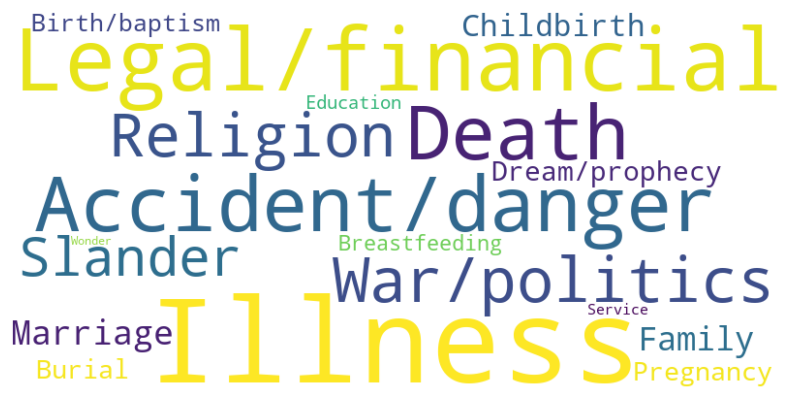

In [153]:
# What is the most common category of event?
from wordcloud import WordCloud

cloud_text = " ".join(event_df['cat'].dropna())
cloud_words = cloud_text.split()
cloud_words_count = Counter(cloud_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(cloud_words_count)
most_common_category = cloud_words_count.most_common(1)[0][0]
most_common_count = cloud_words_count.most_common(1)[0][1]

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes

display(Markdown("### **What is the most common category of event?**"))
print(f'{most_common_category} is the most common category with {most_common_count} events ({(most_common_count / row_count) * 100:.0f}%).')

In [154]:
# How many of the events have different precision or certainty? (e.g. precise/uncertain to the day, month, span of years etc.)

# Count dates in each EDTF class
class_counts = event_df['date_edtf'].apply(lambda x: type(x).__name__).value_counts()

# Get some explanations for the different EDTF class types
with open('edtf-class-info.json', 'r') as file:
    edtf_info = json.load(file)

class_counts_df = class_counts.rename_axis('date_edtf').reset_index(name='count')
class_counts_df['explanation'] = class_counts_df['date_edtf'].map(edtf_info)

display(Markdown("### **How many of the events have different precision or certainty?**"))
display(class_counts_df.style.set_properties(subset=['explanation'], **{'width': '400px', 'text-align': 'left'}))


### **How many of the events have different precision or certainty?**

,date_edtf,count,explanation
0,Date,205,A precise calendar date (e.g. '1979-08-02').
1,UncertainOrApproximate,62,"A date that is either uncertain or approximate or both, indicated with a question mark (?), tilde (~) or percentage (%), respectively (e.g. '1979-08-28~')."
2,Interval,34,A range of dates from one specific date to another (e.g. '1979-08-28/1979-09-25').
3,Level1Interval,16,A date interval where one or both dates may be uncertain or approximate (e.g. '1984-06-02?/2004-08-08~').


In [155]:
# What is the earliest date for an event? (using strict_lower)
earliest_date_index = event_df['date_edtf_lower_strict'].idxmin()
earliest_date_row = event_df.loc[earliest_date_index]
display(Markdown("### **What is the earliest date for an event?**"))
print(f"The earliest date is {earliest_date_row['date_edtf_lower_strict'].strftime('%-d %B, %Y')}, which was {earliest_date_row['title']}.")

### **What is the earliest date for an event?**

The earliest date is 5 January, 1593, which was Birth/baptism: Birth of Alice Wandesford, Thornton's mother.


In [156]:
# What is the latest date? (using strict_upper)
latest_date_index = event_df['date_edtf_upper_strict'].idxmax()
latest_date_row = event_df.loc[latest_date_index]
display(Markdown("### **What is the latest date for an event?**"))
print(f"The latest date is {latest_date_row['date_edtf_lower_strict'].strftime('%-d %B, %Y')}, which was {latest_date_row['title']}.")

### **What is the latest date for an event?**

The latest date is 1 October, 1688, which was Legal/financial: Abstrupus Danby did not fully repay Thornton's costs for his family.


### **Which year has the most events?**

1668 has the most events recorded.


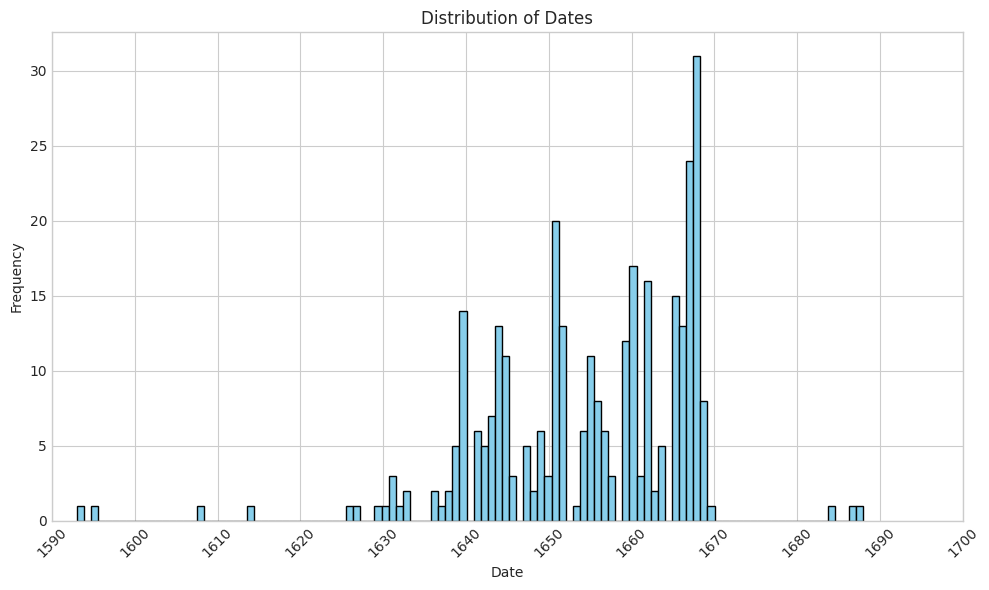

In [157]:
# Which year has the most events?

start_year = 1590  # year of Alice Thornton's birth is 1626; first recorded event is 1593
end_year = 1700 # year of Alice Thornton's death is 1707; no events recorded after 1688

# Extract the year from each date
event_df['date_edtf_lower_strict_year'] = event_df['date_edtf_lower_strict'].apply(lambda date: date.year)

# Improve the default style... slightly
plt.style.use('seaborn-v0_8-whitegrid')

# Plot histogram using built-in Pandas plotting
ax = event_df['date_edtf_lower_strict_year'].plot.hist(
    bins=(end_year - start_year + 1),
    color='skyblue',
    edgecolor='black',
    figsize=(10, 6)
)

# Set labels and title
ax.set_title('Distribution of Dates')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_xlim(start_year, end_year)
ax.set_xticks(range(start_year, end_year + 1, 10))
plt.xticks(rotation=45)
plt.tight_layout()

# Get the frequency of each year
year_counts = event_df['date_edtf_lower_strict_year'].value_counts()
year_with_most_events = year_counts.idxmax().max()

display(Markdown("### **Which year has the most events?**"))
print(f"{year_with_most_events} has the most events recorded.")

In [158]:
# Which decade has the most events?

# Group dates by decade
decade_counts = event_df.groupby((event_df['date_edtf_lower_strict_year'] // 10) * 10).size()

# Find the decade with the most events
decade_with_max_events = decade_counts.idxmax()
max_events_count = decade_counts.max()

display(Markdown("### **Which decade has the most events?**"))
print(f"The decade with the most events is: {int(decade_with_max_events)}s, with {max_events_count} events.")
display(decade_counts)

### **Which decade has the most events?**

The decade with the most events is: 1660s, with 134 events.


date_edtf_lower_strict_year
1590      2
1600      1
1610      1
1620      3
1630     17
1640     72
1650     83
1660    134
1670      1
1680      3
dtype: int64

### **How does this correspond to Alice Thornton's age at the time?**

Age 42 has the most events recorded.


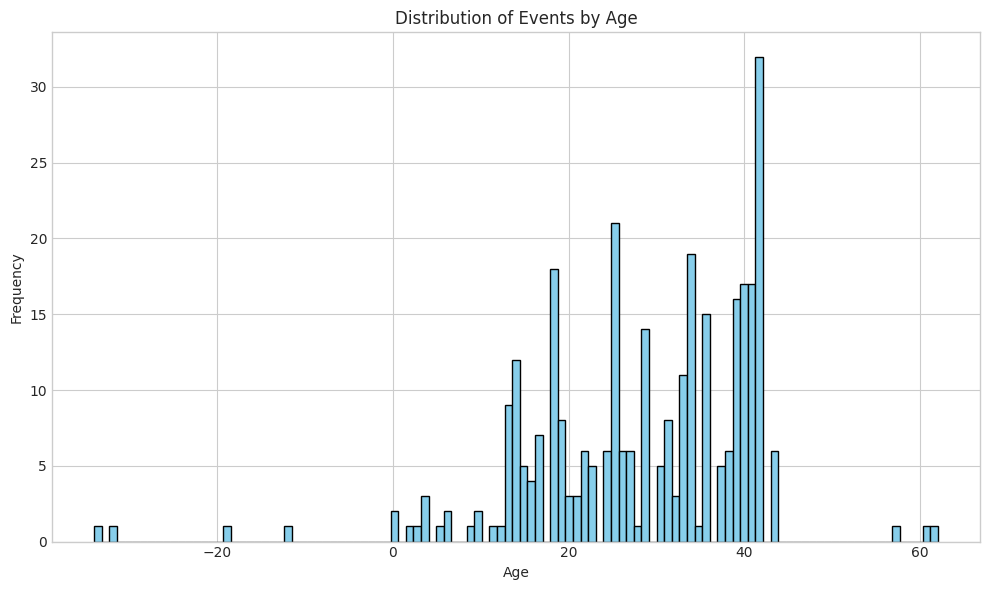

In [159]:
# How does this correspond to Alice Thornton's age at the time?

# Plot histogram using built-in Pandas plotting
ax = event_df['age_at_date_edtf_lower_strict'].plot.hist(
    bins=(end_year - start_year + 1),
    color='skyblue',
    edgecolor='black',
    figsize=(10, 6)
)

# Set labels and title
ax.set_title('Distribution of Events by Age')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
plt.tight_layout()

# Get the frequency of each year
age_counts = event_df['age_at_date_edtf_lower_strict'].value_counts()
age_with_most_events = age_counts.idxmax().max()

display(Markdown("### **How does this correspond to Alice Thornton's age at the time?**"))
print(f"Age {age_with_most_events} has the most events recorded.")


### **Which decade of her life has the most events?**

The decade of her life with the most events is: 30s, with 89 events.


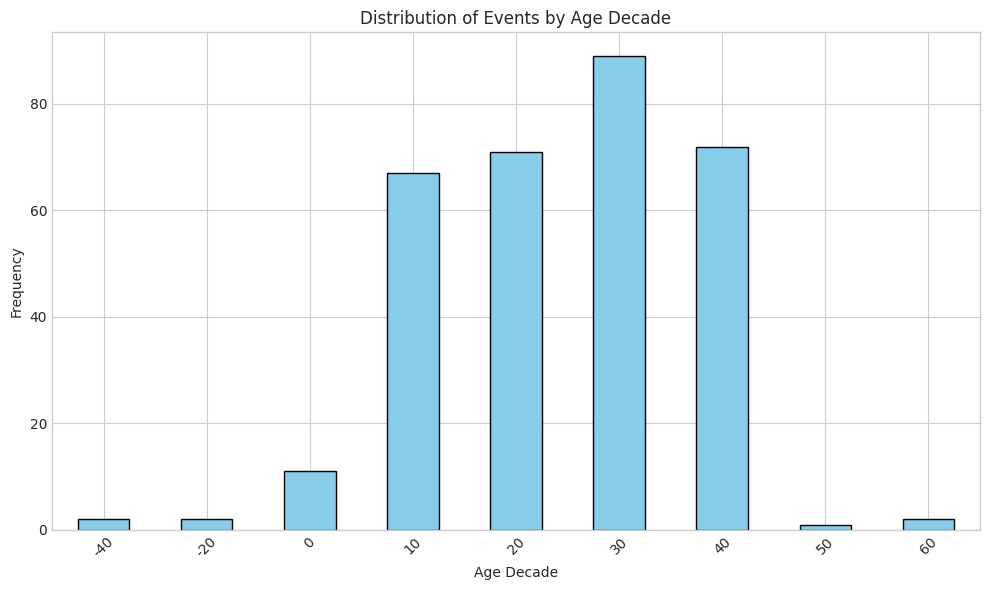

In [160]:
# Which decade of her life has the most events?

# Group dates by decade of life
age_decade_counts = event_df.groupby((event_df['age_at_date_edtf_lower_strict'] // 10) * 10).size()

# Plot as bar chart using built-in Pandas plotting
ax = age_decade_counts.plot.bar(
    color='skyblue',
    edgecolor='black',
    figsize=(10, 6)
)

# Set labels and title
ax.set_title('Distribution of Events by Age Decade')
ax.set_xlabel('Age Decade')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Find the decade of life with the most events
age_decade_with_max_events = age_decade_counts.idxmax()
age_max_events_count = age_decade_counts.max()

display(Markdown("### **Which decade of her life has the most events?**"))
print(f"The decade of her life with the most events is: {int(age_decade_with_max_events)}s, with {age_max_events_count} events.")

### **What is the distribution of events recorded over the phases of her life?**

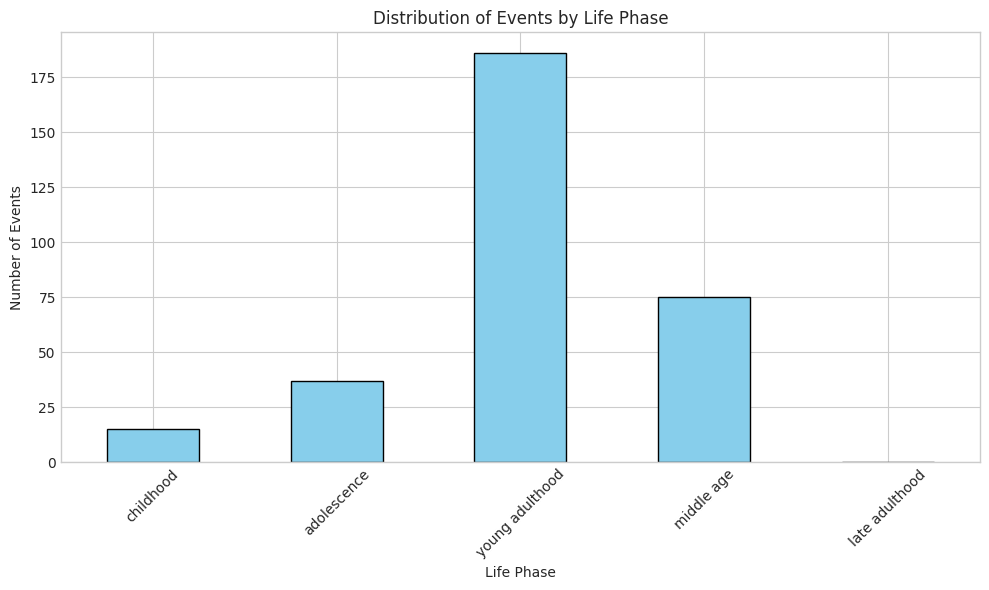

In [161]:
# What is the distribution of events recorded over the phases of her life?

# Create some life phases and corresponding dates. Almost certainly an historian would take issue with these, but it's a start!
age_categories = {
    "childhood": (0, 12),
    "adolescence": (13, 17),
    "young adulthood": (18, 39),
    "middle age": (40, 64),
    "late adulthood": (65, float('inf'))
}

# Function to map ages to categories
def categorise_age(age):
    for category, (lower, upper) in age_categories.items():
        if lower <= age <= upper:
            return category
    return None

# Apply the categorisation function to the age column
event_df['age_category'] = event_df['age_at_date_edtf_lower_strict'].apply(categorise_age)
age_category_counts = event_df['age_category'].value_counts()

# Reorder the counts to match the order of age_categories
ordered_age_category_counts = age_category_counts.reindex(age_categories.keys(), fill_value=0)

# Plot bar chart using built-in Pandas plotting
ax = ordered_age_category_counts.plot.bar(
    color='skyblue',
    edgecolor='black',
    figsize=(10, 6)
)

plt.xlabel('Life Phase')
plt.ylabel('Number of Events')
plt.title('Distribution of Events by Life Phase')
plt.xticks(rotation=45)
plt.tight_layout()

display(Markdown("### **What is the distribution of events recorded over the phases of her life?**"))

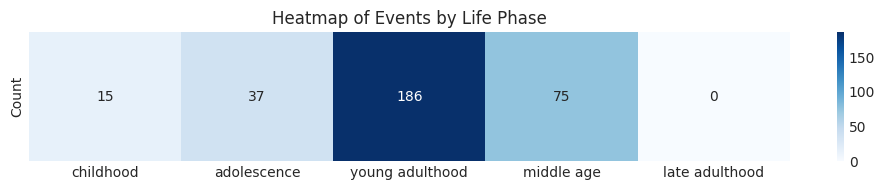

In [162]:
# Bar charts are dull. Is there anything more interesting to do with this data?

# Create a count of each category
heatmap_data = ordered_age_category_counts.values.reshape(1, -1)

# Plot a heatmap with Seaborn
plt.figure(figsize=(10, 2))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=age_categories.keys(), 
    yticklabels=['Count']
)
plt.title('Heatmap of Events by Life Phase')
plt.tight_layout()


### The Four Books

Alice Thornton wrote four books: Book of Rememberences, Book 1, Book 2 and Book 3. They were written at different times and cover slightly different periods in her life. Many of the events are written about in more than one book. It would be interesting to know if there is an interesting story to tell about this.

In [163]:
# What are the periods in which the books were written?

book_writing_periods = {
    "book_of_remembrances": {
        "date_range": (1659, 1673),
        "display_name": "Book of Remembrances",
        "sort_key": 1
    },
    "book_one": {
        "date_range": (1668, 1687),
        "display_name": "Book One",
        "sort_key": 2
    },
    "book_two": {
        "date_range": (1685, 1695),
        "display_name": "Book Two",
        "sort_key": 3
    },
    "book_three": {
        "date_range": (1692, 1696),
        "display_name": "Book Three",
        "sort_key": 4
    }
}

display(Markdown("### **What are the periods in which the books were written?**"))
for book, info in book_writing_periods.items():
    print(f"{info['display_name']}: c. {info['date_range'][0]} - {info['date_range'][1]}")


### **What are the periods in which the books were written?**

Book of Remembrances: c. 1659 - 1673
Book One: c. 1668 - 1687
Book Two: c. 1685 - 1695
Book Three: c. 1692 - 1696


In [164]:
# How many events were written about in each book?

# The dataframe column `books` contains a list of the books in which each event is mentioned
event_df_exploded = event_df.explode('books')
book_counts = event_df_exploded['books'].value_counts()

display(Markdown("### **How many events were written about in each book?**"))

# Extract sort_key for each book
sort_keys = {book: info["sort_key"] for book, info in book_writing_periods.items()}

# Print the number of events mentioned with books in correct sort order
book_counts.sort_index(key=lambda x: x.map(sort_keys))


### **How many events were written about in each book?**

books
book_of_remembrances    146
book_one                229
book_two                151
book_three               99
Name: count, dtype: int64

### **What is the distribution of events written about in each book?**

Overall the books seem to cover events largely over the same period, that is c. 1625 to 1670. Book 3 has fewer events before 1640 than the others and fewer events overall.


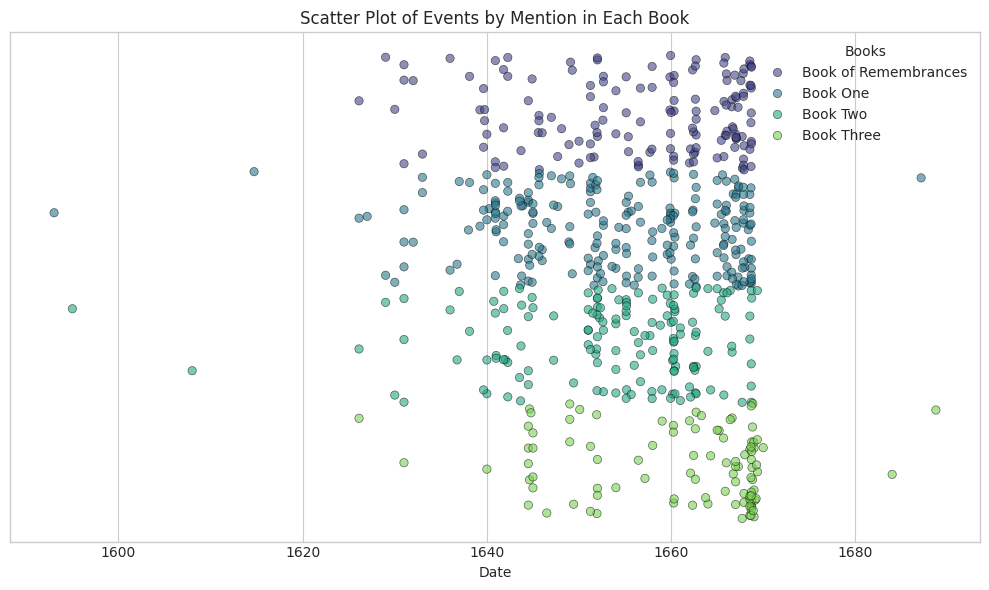

In [165]:
# What is the distribution of events written about in each book?

# Sort the DataFrame by book sort_key to ensure points are plotted in the correct order
event_df_exploded['sort_key'] = event_df_exploded['books'].map(sort_keys)
event_df_exploded = event_df_exploded.sort_values(by='sort_key', ascending=True)

# Add random dither to the y-axis to avoid the points overlapping
np.random.seed(42)  # Seed for reproducibility
# Random values between 0 and 1 with a negative offset by the sort_key
event_df_exploded['random_y'] = np.random.uniform(0, 1, len(event_df_exploded)) - event_df_exploded['sort_key']

# Plot each of these points on a Seaborn scatter plot by date
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=event_df_exploded, x='date_edtf_lower_strict', y='random_y', hue='books', palette='viridis', edgecolor='black', alpha=0.6, )
ax.set(xlabel='Date', ylabel='', title='Scatter Plot of Events by Mention in Each Book')

# Update the legend labels with custom display names and sort by sort_key
handles, labels = ax.get_legend_handles_labels()
display_names = [book_writing_periods[label]['display_name'] for label in labels]
sorted_legend = sorted(zip(handles, display_names, labels), key=lambda x: sort_keys[x[2]])
handles, display_names = zip(*[(h, d) for h, d, l in sorted_legend])
ax.legend(handles=handles, labels=display_names, title='Books')

plt.yticks([])
plt.tight_layout()

display(Markdown("### **What is the distribution of events written about in each book?**"))
print("Overall the books seem to cover events largely over the same period, that is c. 1625 to 1670. " +
      "Book 3 has fewer events before 1640 than the others and fewer events overall.")

### **Can we represent both which book the events were recorded in and the type of event?**

Not really. This quickly becomes a mess.


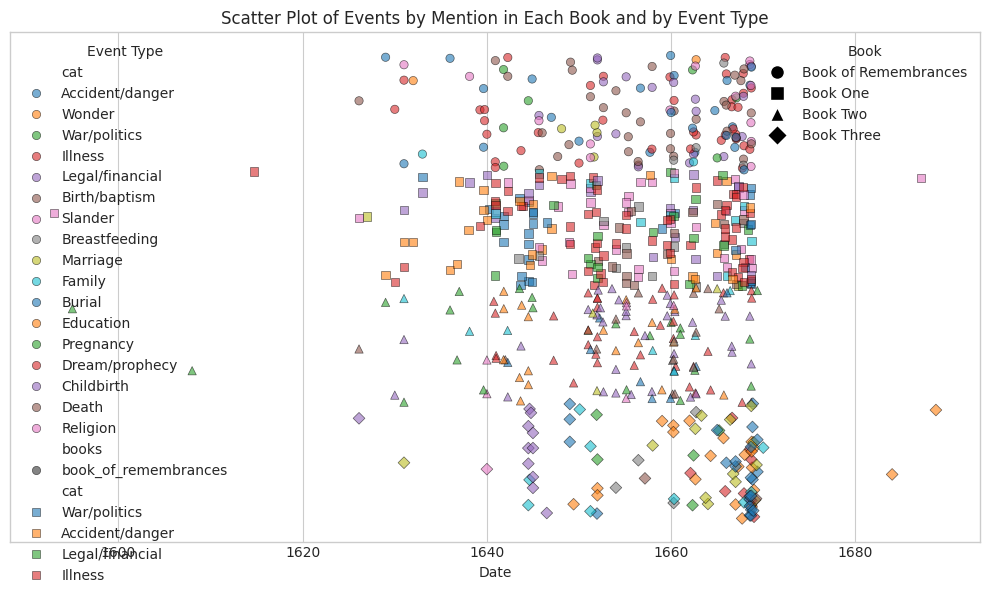

In [166]:
# Can we represent both which book the events were recorded in and the type of event?

marker_dict = {
    'book_of_remembrances': 'o',
    'book_one': 's',
    'book_two': '^',
    'book_three': 'D'
}

plt.figure(figsize=(10, 6))
for book, marker in marker_dict.items():
    subset = event_df_exploded[event_df_exploded['books'] == book]
    sns.scatterplot(
        data=subset, 
        x='date_edtf_lower_strict', 
        y='random_y', 
        hue='cat', 
        style='books', 
        markers=marker_dict, 
        palette='tab10', 
        edgecolor='black', 
        alpha=0.6
    )

# Add separate legends for color and shape
# Legend for colors (Event Types)
handles, labels = plt.gca().get_legend_handles_labels()
event_legend = plt.legend(handles=handles, labels=labels, title='Event Type', loc='upper left')
plt.gca().add_artist(event_legend)


# Legend for markers (Books)
marker_handles = [plt.Line2D([0], [0], marker=marker, color='w', label=book_writing_periods[book]['display_name'],
                             markerfacecolor='black', markersize=10) for book, marker in marker_dict.items()]
plt.legend(handles=marker_handles, title='Book', loc='upper right')

plt.title('Scatter Plot of Events by Mention in Each Book and by Event Type')
plt.xlabel('Date')
plt.ylabel('')
plt.yticks([])
plt.tight_layout()

display(Markdown("### **Can we represent both which book the events were recorded in and the type of event?**"))
print("Not really. This quickly becomes a mess.")

### **Can we can do a simpler scatterplot with a different marker for each type of event?**

Again, this is tough to do without creating a lot of visual noise when all the events are included.


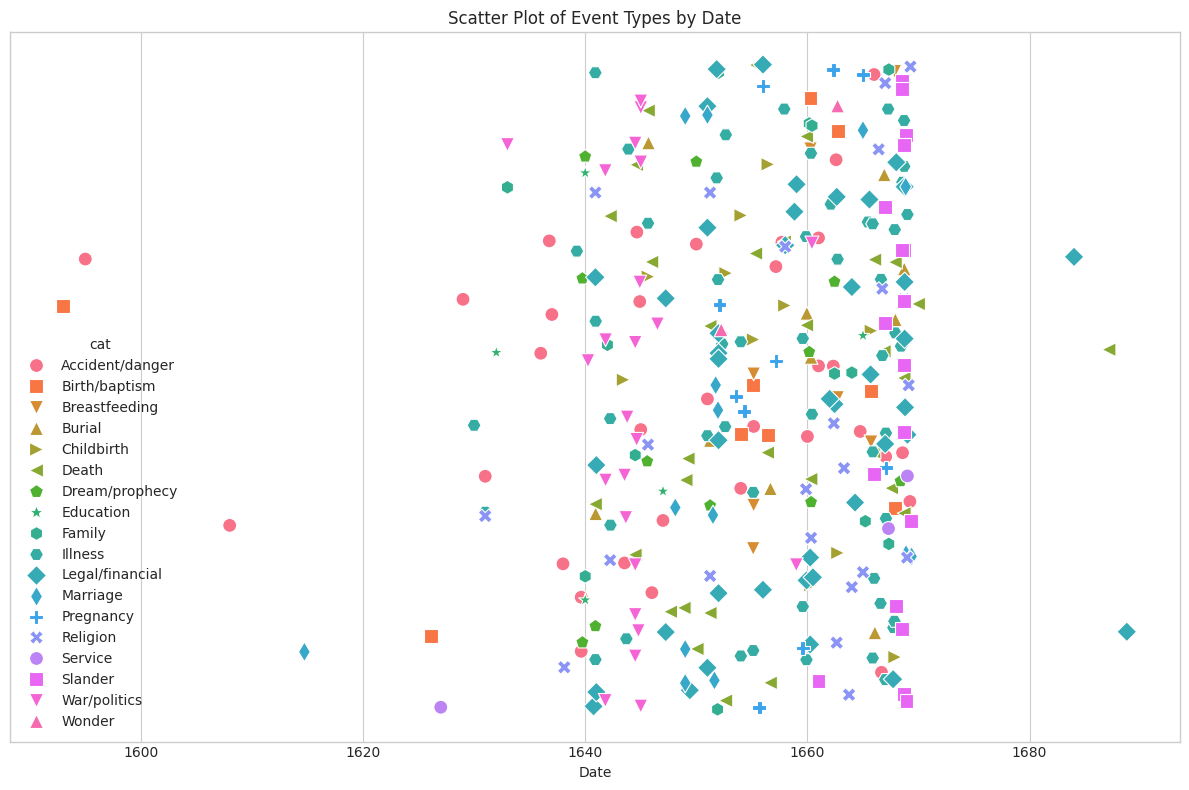

In [167]:
# Can we can do a simpler scatterplot with a different marker for each type of event?

# Add random dither to the y-axis to avoid the points overlapping
np.random.seed(123)  # Seed for reproducibility
# Random values between 0 and 1
event_df['random_y'] = np.random.uniform(0, 1, len(event_df))

markers = ['o', 's', 'v', '^', '>', '<', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 's', 'v', '^']

# Create a scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=event_df,
    x='date_edtf_lower_strict',
    y='random_y',
    hue='cat', 
    style='cat',  # Different marker depending on category
    markers=markers,
    palette='husl',
    s=100
    )

plt.title('Scatter Plot of Event Types by Date')
plt.xlabel('Date')
plt.ylabel('')
plt.yticks([])
plt.tight_layout()

display(Markdown("### **Can we can do a simpler scatterplot with a different marker for each type of event?**"))
print("Again, this is tough to do without creating a lot of visual noise when all the events are included.")

### **Can we see any patterns in the events?**

With selected event categories we can see some interesting patterns. War/politics events happened in her adolescence, pregnancy occured in her early adulthood, whereas illnesses were a lifelong hazard, with a concentration of illnesses around when she turns 40. 


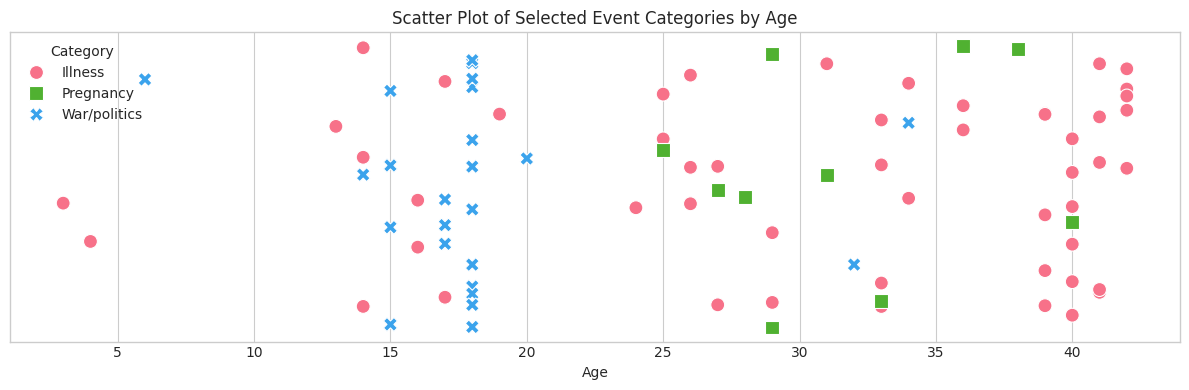

In [168]:
# Can we see any patterns in the events?

# Filter only by the categories we are interested in
filtered_categories = ['Illness', 'War/politics', 'Pregnancy',]
filtered_event_df = event_df[event_df['cat'].isin(filtered_categories)]

markers = ['o', 's', 'X']

# Create a scatterplot
plt.figure(figsize=(12, 4))
sns.scatterplot(
    data=filtered_event_df,
    x='age_at_date_edtf_lower_strict',
    y='random_y',
    hue='cat', 
    style='cat',  # Different marker depending on category
    markers=markers,
    palette='husl',
    s=100
    )

plt.legend(title='Category', loc='upper left')
plt.title('Scatter Plot of Selected Event Categories by Age')
plt.xlabel('Age')
plt.ylabel('')
plt.yticks([])
plt.tight_layout()

display(Markdown("### **Can we see any patterns in the events?**"))
print("With selected event categories we can see some interesting patterns. " +
      "War/politics events happened in her adolescence, pregnancy occured in her early adulthood, whereas illnesses were a lifelong hazard, " +
      "with a concentration of illnesses around when she turns 40. ")

### **Can we superimpose 'important dates' on the events to give them context?**

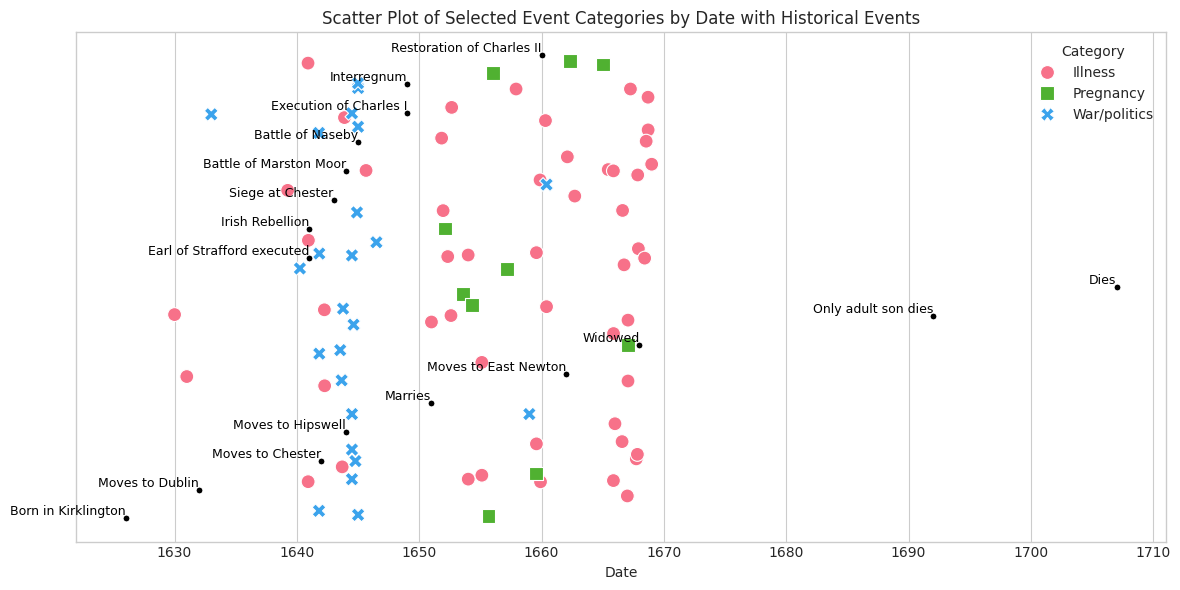

In [169]:
# Can we superimpose important historical dates on the events to give them context?

# Load a dataframe from a list of events provided by the partners
with open('historical-events.json', 'r') as file:
    hist_events = json.load(file)

hist_df = pd.DataFrame(hist_events)

# Convert the year to a datetime.date object so it can be plotted
hist_df['date'] = hist_df['start_year'].apply(lambda start_year: datetime.date(start_year, 1, 1))

# Generate evenly distributed y-values between 0 and 1
hist_df['random_y'] = np.linspace(0, 1, len(hist_df))

# Create the underlying scatterplot (as above)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=filtered_event_df,
    x='date_edtf_lower_strict',
    y='random_y',
    hue='cat', 
    style='cat',
    markers=markers,
    palette='husl',
    s=100
    )

# Superimpose the historical events
sns.scatterplot(
    data=hist_df,
    x='date',
    y='random_y',
    color='black',  # Use a distinct color to highlight the points
    marker='.',   # Use a different marker to make these points stand out
    s=100,        # Increase marker size for visibility
)

# Label each historical event with its name
for _, row in hist_df.iterrows():
    plt.text(
        row['date'],
        row['random_y'],
        row['event'],
        fontsize=9,
        color='black',
        ha='right',
        va='bottom'
    )

plt.legend(title='Category', loc='upper right')
plt.title('Scatter Plot of Selected Event Categories by Date with Historical Events')
plt.xlabel('Date')
plt.ylabel('')
plt.yticks([])
plt.tight_layout()

display(Markdown("### **Can we superimpose 'important dates' on the events to give them context?**"))

# Summary of data exploration

Here are some thoughts about the shape of the data now that we have explored it a little. There is a rich and exciting narrative to tell with this data, with several possible themes to draw out about her lifetime.

## General
* We will need to make some decisions about how best to handle imprecise dates and Alice Thornton's age, since precise dates are needed for plotting, but accurate information may not exist or be awkward to calculate/estimate.
* There are 317 events, which is too many to display comfortably at once if detailed labelling is needed, but it does mean there is plenty of data to play with or select/filter on.
* The earliest recorded event is the birth of Alice Wandesford, Alice Thornton's mother, 33 years before she was born.
* The latest recorded event is in 1688 when Abstrupus Danby did not fully repay Thornton's costs for his family.
* Thornton records the most events in her young adulthood (18-39 years old) with a peak in her 30s, but the most events recorded in a year was when she was 42 years old.

## Books
* There are 4 books. Overall the books seem to cover events largely over the same period, that is c. 1625 to 1670. 
* Book 3 has fewer events before 1640 than the others and fewer events overall.
* Alice Thornton pretty much stops writing about events after she is widowed.

## Event categories
* Illness is the most common category of event with 51 events (16%).
* Interesting patterns in the categories of events in her life appear when fewer event types are displayed. For example, 'War/politics' events happened in her adolescence, 'Pregnancy' occured in her early adulthood during the period of her marriage, whereas 'Illness' was a lifelong hazard, with a concentration of illnesses around when she turns 40.
* Some dates cluster particularly, like those around the war, suggesting that a more detailed focus might help to explore them. Otherwise, these would need be generalised or truncated/selected to avoid cluttering.
* Displaying historical events and other important dates provides context to patterns in the categories of events in her life.
* Further dimensions to the data could be unlocked by correlating the events with their associated people and places, but with so many events to display, to tell a story about her life, the information would have to be presented thoughtfully.

# Save data

We may wish to use this dataframe in another notebook so it is a good idea to save the data. JSON is a good format but it will not preserve our datetime types so we use Parquet instead, even though it is less portable.

Second thought: since we are not trying to preserve `EDTFObject`s there may not be much point in using Parquet since Pandas can handle straight-forward dates itself. But I leave it here for now in case it's useful later.

In [170]:
# This does not work out-of-the-box because the objects from the `edtf` library are not recognised:
# ArrowInvalid: ("Could not convert UncertainOrApproximate: '1595%' with type UncertainOrApproximate: did not recognize Python value type when inferring an Arrow data type", 'Conversion failed for column date_edtf with type object')
# One way round this is to dump the 'date_edtf' column. We still have the original date string column, which can be re-parsed, and we have the derived date columns.

event_df_export = event_df.drop(columns=['date_edtf'])
event_df_export.to_parquet('event_df.parquet')

# Explorations in Interactivity

To explore the data further it is helpful to be able to interact with it in real time. Both the libraries Bokeh and Plotly do this well. For simplicity we will go with Plotly for the moment.

In [171]:
import plotly.express as px
from ipywidgets import widgets

In [177]:
# Can we make an interactive scatterplot with simple category toggles?

# Create a list of unique categories
categories = tuple(event_df['cat'].unique())

# Create a legend widget for filtering categories
legend_selector = widgets.SelectMultiple(
    options=categories,
    value=categories,
    description='Categories',
    disabled=False
)

def update_plot(selected_categories):
    # Filter the dataframe based on selected categories
    filtered_event_df = event_df[event_df['cat'].isin(selected_categories)]
    
    # Create a scatter plot using Plotly
    fig = px.scatter(
        filtered_event_df, 
        x='date_edtf_lower_strict', 
        y='random_y', 
        color='cat', 
        color_discrete_sequence=px.colors.qualitative.Alphabet, # Specify colour palette to try and avoid repeats
        title='Interactive Scatter Plot of Event Categories by Date',
        labels={'date_edtf_lower_strict': 'Date', 'random_y': '', 'cat': 'Category'},
        hover_data=['cat', 'date_edtf_lower_strict']
    )
    
    # Update layout to remove y-axis labels and customize legend
    fig.update_layout(
        legend_title_text='Category',
        height=400,
        width=800,
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgrey', showline=True, linecolor='lightgrey'),
        yaxis=dict(showgrid=True, gridcolor='lightgrey', showline=False, showticklabels=False)
    )
    
    # Show the plot
    fig.show()

display(Markdown("### **Can we make an interactive scatterplot with simple category toggles?**"))
print("This allows the user to choose which categories to display at will and discover patterns for themselves.")

# Create an interactive output for the plot
output = widgets.interactive_output(update_plot, {'selected_categories': legend_selector})


### **Can we make an interactive scatterplot with simple category toggles?**

This allows the user to choose which categories to display at will and discover patterns for themselves.


In [178]:
# Can we distinguish the categories and display the number of events with size?

# Create a tuple of unique categories and create distinct y-axis position for each
categories = tuple(event_df['cat'].unique())
category_counts = event_df['cat'].value_counts()
categories_sorted = category_counts.index.tolist()
category_positions = {category: index + 1 for index, category in enumerate(categories_sorted)}

# Create a legend widget for filtering categories
legend_selector = widgets.SelectMultiple(
    options=categories,
    value=categories,
    description='Categories',
    disabled=False,
)

# Pick out just the year to plot
event_df['year'] = event_df['date_edtf_lower_strict'].apply(lambda x: x.year)

# Set the y-axis position based on the category group
event_df['y_position'] = event_df['cat'].map(category_positions)

def update_plot(selected_categories):
    # Filter the dataframe based on selected categories
    filtered_event_df = event_df[event_df['cat'].isin(selected_categories)]
    
    # Aggregate the number of events per year and category
    aggregated_df = filtered_event_df.groupby(['year', 'cat', 'y_position']).size().reset_index(name='count')
    
    # Create a scatter plot using Plotly
    fig = px.scatter(
        aggregated_df, 
        x='year', 
        y='y_position', 
        size='count', 
        color='cat', 
        color_discrete_sequence=px.colors.qualitative.Light24,
        title='Interactive Scatter Plot of Event Counts by Year',
        labels={'year': 'Year', 'count': 'Number of Events', 'cat': 'Category', 'y_position': ''},
        hover_data={'year': True, 'cat': True, 'count': True, 'y_position': False}
    )
    
    # Update layout to customize legend, add axis lines, and use a white background
    fig.update_layout(
        legend_title_text='Category',
        height=400,
        width=800,
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgrey', showline=True, linecolor='lightgrey'),
        yaxis=dict(showline=True, linecolor='black', showgrid=True, gridcolor='lightgrey', tickmode='array', tickvals=list(category_positions.values()), ticktext=[category for category in categories_sorted])
    )
    
    # Show the plot
    fig.show()

display(Markdown("### **Can we distinguish the categories and display the number of events with size?**"))
print("This is much clearer and shows how some categories have hardly any events while others have many. " +
      "It also shows that most years have only 1 or 2 events per category. " +
      "NB: Weird bug in legend selector affects the order of categories - sorry!"
      )

# Create an interactive output for the plot
output = widgets.interactive_output(update_plot, {'selected_categories': legend_selector})



### **Can we distinguish the categories and display the number of events with size?**

This is much clearer and shows how some categories have hardly any events while others have many. It also shows that most years have only 1 or 2 events per category. NB: Weird bug in legend selector affects the order of categories - sorry!


In [179]:
# Can we group the categories to reduce the visual noise?

# Define group category mappings
groups = {
    'Beginnings': ['Pregnancy', 'Childbirth', 'Birth/baptism'],
    'Growth': ['Marriage', 'Family', 'Breastfeeding'],
    'Mortality': ['Illness', 'Death', 'Burial', 'Accident/danger'],
    'Challenges': ['War/politics', 'Slander', 'Legal/financial'],
    'Spiritual': ['Religion', 'Dream/prophecy', 'Education', 'Wonder']
}
# Create a tuple of the unique group names
group_names = tuple(groups.keys())

# Create a new column in event_df mapping 'cat' to 'category_group'
def map_category_to_group(cat):
    for group, items in groups.items():
        if cat in items:
            return group
    return None
event_df['category_group'] = event_df['cat'].apply(map_category_to_group)

# Pick out just the year to plot
event_df['year'] = event_df['date_edtf_lower_strict'].apply(lambda x: x.year)

# Set the y-axis position based on the category group
group_positions = {group: index + 1 for index, group in enumerate(group_names)}
event_df['y_position'] = event_df['category_group'].map(group_positions)

# Create a checkbox widget for filtering category groups
legend_selector = widgets.SelectMultiple(
    options=group_names,
    value=group_names,
    description='Groups',
    disabled=False
)

def update_plot(selected_groups):
    # Filter the dataframe based on selected groups
    filtered_event_df = event_df[event_df['category_group'].isin(selected_groups)]
    
    # Aggregate the number of events per year and group
    aggregated_df = filtered_event_df.groupby(['year', 'category_group', 'y_position']).size().reset_index(name='count')
    
    # Create a scatter plot using Plotly, with each group on a different line and point size representing count
    fig = px.scatter(
        aggregated_df, 
        x='year', 
        y='y_position', 
        size='count', 
        color='category_group', 
        color_discrete_sequence=px.colors.qualitative.Light24,
        title='Interactive Scatter Plot of Event Counts by Category Group and Year',
        labels={'year': 'Year', 'count': 'Number of Events', 'category_group': 'Group', 'y_position': ''},
        hover_data={'year': True, 'category_group': True, 'count': True, 'y_position': False}
    )
    
    # Update layout to customize legend, add axis lines, and use a white background
    fig.update_layout(
        legend_title_text='Category Group',
        height=400,
        width=800,
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgrey', showline=True, linecolor='lightgrey'),
        yaxis=dict(showline=True, linecolor='black', showgrid=True, gridcolor='lightgrey', tickmode='array', tickvals=list(group_positions.values()), ticktext=[group for group in group_names])
        )
    
    # Show the plot
    fig.show()

display(Markdown("### **Can we group the categories to reduce the visual noise?**"))
print(" " )

# Create an interactive output for the plot
output = widgets.interactive_output(update_plot, {'selected_groups': legend_selector})



### **Can we group the categories to reduce the visual noise?**

In [ ]:
# Can we display these category groupings on one line?

event_df['y_position'] = event_df['category_group'].map(lambda x: 1)

# Create a checkbox widget for filtering category groups
legend_selector = widgets.SelectMultiple(
    options=group_names,
    value=group_names,
    description='Groups',
    disabled=False
)

def update_plot(selected_groups):
    # Filter the dataframe based on selected groups
    filtered_event_df = event_df[event_df['category_group'].isin(selected_groups)]
    
    # Aggregate the number of events per year and group
    aggregated_df = filtered_event_df.groupby(['date_edtf_lower_strict', 'category_group', 'y_position']).size().reset_index(name='count')
    
    # Create a scatter plot using Plotly, with each category on a different line and point size representing count
    fig = px.scatter(
        aggregated_df, 
        x='date_edtf_lower_strict', 
        y='y_position', 
        size='count', 
        color='category_group', 
        color_discrete_sequence=px.colors.qualitative.Light24,
        title='Interactive Line of Event Counts by Category Group and Date',
        labels={'date_edtf_lower_strict': 'Date', 'count': 'Number of Events', 'category_group': 'Group', 'y_position': ''},
        hover_data={'date_edtf_lower_strict': True, 'category_group': True, 'count': True, 'y_position': False}
    )
    
    # Update layout to customize legend, add axis lines, and use a white background
    fig.update_layout(
        legend_title_text='Category Group',
        height=400,
        width=800,
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgrey', showline=True, linecolor='lightgrey'),
        yaxis=dict(showline=True, showticklabels=False, showgrid=True, gridcolor='black', linecolor='black', tickvals=[1], ticktext=[''])
        )
    
    # Show the plot
    fig.show()

display(Markdown("### **Can we display these category groupings on one line using the precise dates?**"))
print("With all the groups showing, parts of the plot are quite crowded, even when zooming in to allow space to show full years. " +
      "With everything on one line it is hard to discern many patterns with just size and colour to distinguish the points." + 
      "The groups feel quite abstract so it is hard to get a feel for what the line is showing."
      )

output = widgets.interactive_output(update_plot, {'selected_groups': legend_selector})




### **Can we display these category groupings on one line using the precise dates?**

With all the groups showing, parts of the plot are quite crowded, even when zooming in to allow space to show full years. With everything on one line it is hard to discern many patterns with just size and colour to distinguish the points.The groups feel quite abstract so it is hard to get a feel for what the line is showing.
